### 1. What is the purpose of this experiment?
LGBMをアンサンブルの1つとするにあたり、ベンチマークを作成する。
F1 Scoreと学習に使う時間を確認する。
また、TFIDFとEmbeddingの2通りを試す
### 2. Why do you this?
多様なモデルを作る為
### 3. Where are the points of technology and techniques?
LGBM
TFIDF
### 4. How do you validate the effectiveness?
処理時間
F1 Score
### 5. What will you do next?
NNとアンサンブルしてLBを確認する。学習時間を確認する

In [1]:
is_local = False
seed = 1208
st_time = time.time()

%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
from contextlib import contextmanager
import datetime
import sys
import re
import gc
import glob
import pickle as pkl
import os

from joblib import Parallel, delayed
from multiprocessing import Pool
import multiprocessing
def pararell_process(func, arg_list, cpu_cnt=multiprocessing.cpu_count()):
    process = Pool(cpu_cnt)
    callback = process.map_async(func, arg_list).get(600)
    process.close()
    process.terminate()
    return callback

def mkdir_func(path):
    try:
        os.stat(path)
    except:
        os.mkdir(path)

from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger
def logger_func():
    logger = getLogger(__name__)
    log_fmt = Formatter('%(asctime)s %(name)s %(lineno)d [%(levelname)s]\
    [%(funcName)s] %(message)s ')
    handler = StreamHandler()
    handler.setLevel('INFO')
    handler.setFormatter(log_fmt)
    logger.addHandler(handler)

    mkdir_func('../output')
    handler = FileHandler('../output/py_train.py.log', 'a')
    handler.setLevel(DEBUG)
    handler.setFormatter(log_fmt)
    logger.setLevel(DEBUG)
    logger.addHandler(handler)

    logger.info('start')

    return logger
logger = logger_func()


@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
# NLP
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string

key = 'qid'
qt = 'question_text'
target = 'target'

2018-11-25 15:47:20,392 __main__ 50 [INFO]    [logger_func] start 


### Cleansing Method

In [2]:
# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    """ Simple text clean up process"""
    # 1. Go to lower case (only good for english)
    # Go to bytes_strings as I had issues removing all \n in r""
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Drop \n and  \t
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    # 3. Replace english contractions
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Drop puntuation
    # I could have used regex package with regex.sub(b"\p{P}", " ")
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Drop numbers - as a scientist I don't think numbers are toxic ;-)
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Remove extra spaces - At the end of previous operations we multiplied space accurences
    clean = re.sub(b'\s+', b' ', clean)
    # Remove ending space if any
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Now replace words by words surrounded by # signs
    # e.g. my name is bond would become #my# #name# #is# #bond#
    # clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
#     clean = re.sub(b" ", b"# #", clean)  # Replace space
#     clean = b"#" + clean + b"#"  # add leading and trailing #

    return str(clean, 'utf-8')

def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))

def cleansing_text(text, remove_stopwords=True):

    # Convert words to lower case and split them
    text = re.sub("_", " ", text, flags=re.IGNORECASE)
    text = text.lower().split()
    regex_num = re.compile(u"[0-9０-９]")

    # Optionally, remove stop words
    if remove_stopwords:
        stops = STOPWORDS
        text = [w for w in text if (not w in stops) and not(regex_num.match(w))]

    text = " ".join(text)

    # Clean the text
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub("\'ve", " have ", text)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("`", "'", text) # special single quote
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("é", "e", text)
    text = re.sub("’", "'", text) # special single quote
    text = re.sub("“", '"', text) # special double quote
    text = re.sub("…", " ", text)
    text = re.sub("？", "?", text)
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\W|^)([0-9]+)[kK](\W|$)", r"\1\g<2>000\3", text) # better regex provided by @armamut
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"what's", "what is ", text)

    # Original
    text = re.sub(r" u s ", " America ", text)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" qoura ", " Quora ", text)
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r"(?=[a-zA-Z])ig ", "ing ", text)
    
    return text

### Data Load

In [3]:
def quara_load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    return train, test

train, test = quara_load_data()
# Load id Text List
train_id_list = list(train[key].values)
test_id_list = list(test[key].values)
train_text_list = list(train[qt].values)
test_text_list = list(test[qt].values)
id_list = train_id_list + test_id_list
text_list = train_text_list + test_text_list

raw_trn_idx = list(train.index)
raw_test_idx = list(test.index)
y = train[target]

del train, test
gc.collect()

print(train_text_list[:10])

['How did Quebec nationalists see their province as a nation in the 1960s?', 'Do you have an adopted dog, how would you encourage people to adopt and not shop?', 'Why does velocity affect time? Does velocity affect space geometry?', 'How did Otto von Guericke used the Magdeburg hemispheres?', 'Can I convert montra helicon D to a mountain bike by just changing the tyres?', 'Is Gaza slowly becoming Auschwitz, Dachau or Treblinka for Palestinians?', 'Why does Quora automatically ban conservative opinions when reported, but does not do the same for liberal views?', 'Is it crazy if I wash or wipe my groceries off? Germs are everywhere.', 'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?', 'Is it just me or have you ever been in this phase wherein you became ignorant to the people you once loved, completely disregarding their feelings/lives so you get to have something go your way and feel temporarily at ease. How did things change?']


### Cleansing Start

In [4]:
# Cleansing
with timer("Cleansing Dataset"):
    # 並列処理でクレンジング
    train_text_list = Parallel(n_jobs=-1)( [delayed(cleansing_text)(args) for args in train_text_list] )
    train_text_list = Parallel(n_jobs=-1)( [delayed(prepare_for_char_n_gram)(args) for args in train_text_list] )
    test_text_list = Parallel(n_jobs=-1)( [delayed(cleansing_text)(args) for args in test_text_list] )
    test_text_list = Parallel(n_jobs=-1)( [delayed(prepare_for_char_n_gram)(args) for args in test_text_list] )
    text_list = train_text_list + test_text_list

[Cleansing Dataset] done in 63 s


### TFIDF
ngramはいくつかパターンを試す
実験のため、tfidf matrixとvecotorizerは保存しておく

In [5]:
ngram_range=(1,1)
# ngram_range=(1,2)

def get_tfidf(text_list):
    '''
    Explain:
        テキストを1要素としてもったリストを渡し、TFIDFベクトルをもったsparse matrixを出力する
    Args:
        text_list(list): split前のテキストリスト. 1テキストが1つのTFIDFベクトルに変換される
    Return:
        sparse csr_matrix: TFIDF値が入ったスパースな行列
    '''
    # Get the tfidf
    with timer("Fitting TFIDF"):
        # TFIDFに変換するオブジェクトを作成する
        tfidf_vectorizer = TfidfVectorizer(
            max_features = 10000,
            min_df=10,
            max_df=0.5,
            stop_words="english",
            analyzer='word',
            #  analyzer='char',
            strip_accents='unicode',
            ngram_range=ngram_range,
            use_idf=True,
            smooth_idf=True,
            sublinear_tf=True
        ).fit(text_list)

    # Train, Testのテキストが順番に並んだリストを渡すと、各テキストをTFIDFベクトルに変換して返してくれる
    # テキストに対応するインデックスを渡して返ってくるのが対応するTFIDFベクトル
    with timer("Transform TFIDF"):
        csr_tfidf = tfidf_vectorizer.transform(text_list)
    return csr_tfidf, tfidf_vectorizer

# TFIDF
csr_tfidf, tfidf_vectorizer = get_tfidf(text_list)

# Kernel実行の場合は分岐
if is_local:
    HOME = os.path.expanduser("~")
    sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
    import utils
    utils.to_pkl_gzip(obj=tfidf_vectorizer, path='../input/bench_vectorizer_tfidf30000.gz')
    utils.to_pkl_gzip(obj=csr_tfidf, path='../input/bench_csr_tfidf30000.gz')
    sys.path.append(f'{HOME}/kaggle/data_analysis/model')
    from params_lgbm import params_quara
else:
    del text_list
    gc.collect()

[Fitting TFIDF] done in 11 s
[Transform TFIDF] done in 10 s


### LGBM

In [31]:
train_st_time = time.time()
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix, f1_score, accuracy_score
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

# Variables
try:
    tfidf_vocablary = tfidf_vectorizer.vocabulary_.items()
    feature_list = np.array(tfidf_vectorizer.get_feature_names())
    del tfidf_vectorizer
    gc.collect()
except NameError:
    pass

def f1_calculation(y_val, y_pred):
    for thresh in np.arange(0.1, 0.401, 0.01):
        thresh = np.round(thresh, 2)
        f1 = f1_score(y_val, (y_pred>thresh).astype(int))
        logger.info(f"F1 score at threshold {thresh} is {f1}")
        
        
# Memory Error
def start_svd(df_tfidf, dim=1000):
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=dim, random_state=seed)
    svd_tfidf = svd.fit_transform(df_tfidf)
#     col_names = [f"svd{dim}_tfidf_{i}" for i in range(dim)]
#     df_svd = pd.DataFrame(svd_tfidf, columns=col_names)
    return svd_tfidf
    

def lgbm_train(train_test, feature_list, fold):

    # LGBM Args
    model_type = 'lgb'
    fold_type = 'stratified'
    metric = 'accuracy'
#     fold = 5
    learning_rate = 0.1
    early_stopping_rounds = 100
    num_boost_round = 10000
    seed = 1208
    params = {
        'num_threads': -1,
        'metric': 'binary_logloss',
        'objective': 'binary',
        'boosting_type':'gbdt',
        'bagging_freq': 1,
        'sigmoid': 1.1,
        'subsample': 0.9,
        'colsample_bytree': 0.2,
        'lambda_l1': 1,
        'lambda_l2': 5,
        'learning_rate': 0.1,
        'num_leaves': 100,
        'max_depth': 9,
        'bagging_seed': 1208,
        'data_random_seed': 1208,
        'feature_fraction_seed': 1208,
        'random_seed': 1208,
        'verbose': 1
    }

    # Result
    select_features = [] # Feature Importanceによって選択したfeature群を入れるリスト
    prediction = np.zeros(len(raw_trn_idx))

    with timer("LGBM Setting"):

        # testも結合されてるので、trainのみにする
#         tmp_train = csr_tfidf[raw_trn_idx]
        tmp_train = train_test[raw_trn_idx]

        ' KFold '
        if fold_type == 'stratified':
            folds = StratifiedKFold(n_splits=fold, shuffle=True, random_state=seed)
            kfold = folds.split(tmp_train, y)

    cv_feim = pd.DataFrame() # Feature Importanceの結果ファイルを入れるDF
    for n_fold, (trn_idx, val_idx) in enumerate(kfold):

        with timer(f"Validation: {n_fold} | LGBM Train"):
            x_train, y_train = tmp_train[trn_idx], y[trn_idx]
            x_val, y_val = tmp_train[val_idx], y[val_idx]

            # Dataset
            lgb_train = lgb.Dataset(data=x_train, label=y_train)
            lgb_eval = lgb.Dataset(data=x_val, label=y_val)

            estimator = lgb.train(
                train_set=lgb_train,
                valid_sets=lgb_eval,
                params=params,
                verbose_eval=200,
                early_stopping_rounds=early_stopping_rounds,
                num_boost_round=num_boost_round
            )

        with timer(f"Validation: {n_fold} | Prediction & Get F1 score"):
            y_pred = estimator.predict(x_val)
            score = log_loss(y_val, y_pred)
            logger.info(f'Fold No: {n_fold} | {metric}: {score}')
            logger.info(f"Train Shape: {x_train.shape}")
            
            prediction[val_idx] = y_pred
            
            f1_calculation(y_val, y_pred)

            ' Feature Importance '
            if len(cv_feim):
                cv_feim[f'{n_fold}_importance'] = estimator.feature_importance(importance_type='gain')
            else:
                feim_name = f'{n_fold}_importance'
                feim = pd.Series(estimator.feature_importance(importance_type='gain'), name=feim_name, index=feature_list).to_frame().reset_index().rename(columns={'index':'feature'})
                cv_feim = feim.copy()
                
    f1_calculation(y, prediction)

    with timer("Save Feature Importance"):
        col_feim = [col for col in cv_feim.columns if col.count('importance')]
        cv_feim['avg_importance'] = cv_feim[col_feim].mean(axis=1)
        cv_feim.sort_values(by='avg_importance', ascending=False, inplace=True)

        from matplotlib import pyplot as plt
        import japanize_matplotlib
        %matplotlib inline
        import seaborn as sns
        plt.figure(figsize=(8, 12))
        display(cv_feim.head())
        sns.barplot(data=cv_feim.iloc[:50, ], x='avg_importance', y='feature')
        plt.show()
        if is_local:
            cv_feim.to_csv(f'../valid/{start_time[4:12]}_{model_type}_TFIDF_f1{f1}_logloss{score}_lr{learning_rate}.csv', index=False)
        tmp_features = list(cv_feim[cv_feim['avg_importance']>30]['feature'].values)
        print(f'Selece Feature: {len(tmp_features)}')
        select_features += tmp_features

    select_features = list(set(select_features))
    print(len(select_features))
    print(sorted(select_features)[:20])
    print(f'All done in {time.time() - train_st_time:.0f} s')
    
    return select_features, prediction

[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.149783
[400]	valid_0's binary_logloss: 0.142174
[600]	valid_0's binary_logloss: 0.13824
[800]	valid_0's binary_logloss: 0.135716
[1000]	valid_0's binary_logloss: 0.133919
[1200]	valid_0's binary_logloss: 0.132683
[1400]	valid_0's binary_logloss: 0.13171
[1600]	valid_0's binary_logloss: 0.130919
[1800]	valid_0's binary_logloss: 0.130336
[2000]	valid_0's binary_logloss: 0.129831
[2200]	valid_0's binary_logloss: 0.12945
[2400]	valid_0's binary_logloss: 0.129118
[2600]	valid_0's binary_logloss: 0.128843
[2800]	valid_0's binary_logloss: 0.128607
[3000]	valid_0's binary_logloss: 0.12841
[3200]	valid_0's binary_logloss: 0.128262
[3400]	valid_0's binary_logloss: 0.128119
[3600]	valid_0's binary_logloss: 0.128018
[3800]	valid_0's binary_logloss: 0.127899
[4000]	valid_0's binary_logloss: 0.12786
[4200]	valid_0's binary_logloss: 0.127824
[4400]	valid_0's binary_logloss: 0.12

2018-11-25 17:11:00,163 __main__ 103 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.12776392562946248 
2018-11-25 17:11:00,164 __main__ 104 [INFO]    [lgbm_train] Train Shape: (653061, 10000) 
2018-11-25 17:11:00,260 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5450940193920246 
2018-11-25 17:11:00,352 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5544137480965847 
2018-11-25 17:11:00,444 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5619745731537723 
2018-11-25 17:11:00,537 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5677995827717983 
2018-11-25 17:11:00,627 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5725736917406504 
2018-11-25 17:11:00,718 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5770721801735278 
2018-11-25 17:11:00,808 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5798057249558015 
2018-11-25 17:11

[Validation: 0 | Prediction & Get F1 score] done in 24 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.149197
[400]	valid_0's binary_logloss: 0.141657
[600]	valid_0's binary_logloss: 0.137881
[800]	valid_0's binary_logloss: 0.135454
[1000]	valid_0's binary_logloss: 0.133681
[1200]	valid_0's binary_logloss: 0.132425
[1400]	valid_0's binary_logloss: 0.131454
[1600]	valid_0's binary_logloss: 0.130697
[1800]	valid_0's binary_logloss: 0.130054
[2000]	valid_0's binary_logloss: 0.129557
[2200]	valid_0's binary_logloss: 0.129154
[2400]	valid_0's binary_logloss: 0.128823
[2600]	valid_0's binary_logloss: 0.12857
[2800]	valid_0's binary_logloss: 0.128328
[3000]	valid_0's binary_logloss: 0.128128
[3200]	valid_0's binary_logloss: 0.127971
[3400]	valid_0's binary_logloss: 0.127868
[3600]	valid_0's binary_logloss: 0.127773
[3800]	valid_0's binary_logloss: 0.127694
[4000]	valid_0's binary_logloss: 0.127647
[4200]	valid_0's binary_logloss: 0.127623
[44

2018-11-25 17:13:51,891 __main__ 103 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.12754651043204399 
2018-11-25 17:13:51,892 __main__ 104 [INFO]    [lgbm_train] Train Shape: (653061, 10000) 
2018-11-25 17:13:51,994 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.543802430946657 
2018-11-25 17:13:52,093 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5533769063180828 
2018-11-25 17:13:52,201 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5612167847254683 
2018-11-25 17:13:52,302 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5677554113754413 
2018-11-25 17:13:52,404 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5728836706435766 
2018-11-25 17:13:52,505 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5772981583650634 
2018-11-25 17:13:52,608 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5804972912904569 
2018-11-25 17:13:

[Validation: 1 | Prediction & Get F1 score] done in 24 s


2018-11-25 17:13:55,259 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5444483662767245 
2018-11-25 17:13:55,486 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.553895722216175 
2018-11-25 17:13:55,726 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5615960413289567 
2018-11-25 17:13:55,967 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5677775109452645 
2018-11-25 17:13:56,190 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.572728608466085 
2018-11-25 17:13:56,419 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5771851851851851 
2018-11-25 17:13:56,658 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5801516866202077 
2018-11-25 17:13:56,881 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.5829334848192821 
2018-11-25 17:13:57,105 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 0.5854

,feature,0_importance,1_importance,avg_importance
6558,people,30819.320544,27683.771392,29251.545968
9301,trump,20721.227894,33735.351395,27228.289644
9886,women,29958.725800,22940.338598,26449.532199
5911,muslims,26082.225921,25087.350905,25584.788413
343,americans,18207.443655,17125.304546,17666.374100


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


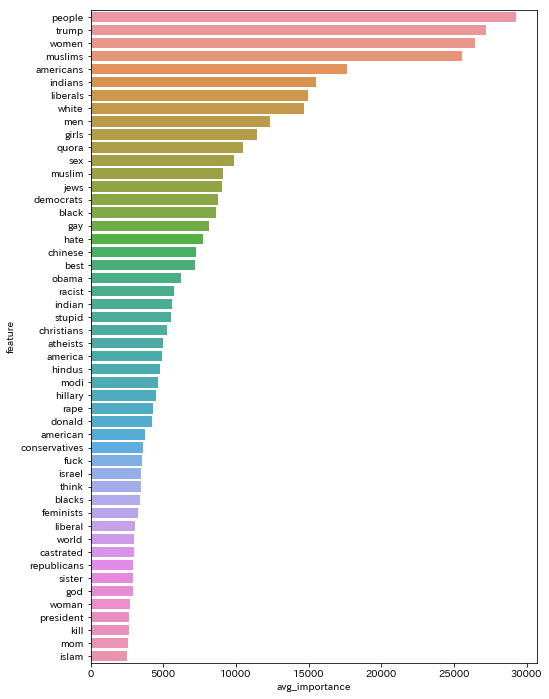

Selece Feature: 2046
[Save Feature Importance] done in 0 s
2046
['aap', 'ability', 'able', 'abortion', 'abortions', 'abuse', 'abusing', 'accept', 'acceptable', 'according', 'account', 'achieve', 'acknowledge', 'act', 'acting', 'actions', 'active', 'activists', 'actually', 'adam', 'add', 'address', 'administration', 'admission', 'admit', 'adolf', 'ads', 'adult', 'advantages', 'advice', 'affairs', 'affect', 'affected', 'afghan', 'afraid', 'africa', 'african', 'africans', 'age', 'agenda', 'agents', 'aggressive', 'ago', 'agree', 'aids', 'air', 'aircraft', 'aka', 'al', 'albanians', 'alex', 'alien', 'aliens', 'alive', 'allah', 'allow', 'allowed', 'allowing', 'alt', 'amazon', 'amendment', 'america', 'american', 'americans', 'analysis', 'ancestors', 'ancient', 'android', 'angry', 'animal', 'animals', 'anime', 'annex', 'annoy', 'annoying', 'answer', 'answering', 'answers', 'anti', 'antifa', 'anus', 'anxiety', 'anybody', 'anymore', 'apartheid', 'apologize', 'app', 'apparently', 'application', 'a

In [32]:
tmp_train = csr_tfidf
select_features, _ = lgbm_train(tmp_train, feature_list, fold=2)

### Feature Importance 上位のFeature Set

In [29]:
id_list = []
[id_list.append(id)  for word, id in tfidf_vocablary if word in select_features]
print(len(id_list))
print(len(select_features))
# sparse matrixのcolumn No=id No
select_mx = csr_tfidf.T[id_list].T
print(select_mx.shape)

2509
2509
(1362492, 2509)


[LGBM Setting] done in 0 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.149038
[400]	valid_0's binary_logloss: 0.141039
[600]	valid_0's binary_logloss: 0.136951
[800]	valid_0's binary_logloss: 0.13435
[1000]	valid_0's binary_logloss: 0.132534
[1200]	valid_0's binary_logloss: 0.131187
[1400]	valid_0's binary_logloss: 0.130145
[1600]	valid_0's binary_logloss: 0.129368
[1800]	valid_0's binary_logloss: 0.128706
[2000]	valid_0's binary_logloss: 0.128178
[2200]	valid_0's binary_logloss: 0.127725
[2400]	valid_0's binary_logloss: 0.127358
[2600]	valid_0's binary_logloss: 0.12707
[2800]	valid_0's binary_logloss: 0.126835
[3000]	valid_0's binary_logloss: 0.126625
[3200]	valid_0's binary_logloss: 0.12649
[3400]	valid_0's binary_logloss: 0.126363
[3600]	valid_0's binary_logloss: 0.126269
[3800]	valid_0's binary_logloss: 0.126214
[4000]	valid_0's binary_logloss: 0.126161
[4200]	valid_0's binary_logloss: 0.126144
Early stopping, best iteration is:


2018-11-25 16:58:08,840 __main__ 103 [INFO]    [lgbm_train] Fold No: 0 | accuracy: 0.1261289392702548 
2018-11-25 16:58:08,841 __main__ 104 [INFO]    [lgbm_train] Train Shape: (1044897, 2509) 
2018-11-25 16:58:08,878 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5477877400881977 
2018-11-25 16:58:08,913 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5573671105337231 
2018-11-25 16:58:08,947 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5647022069488764 
2018-11-25 16:58:08,980 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.571769785494465 
2018-11-25 16:58:09,014 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5776331612081771 
2018-11-25 16:58:09,048 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5830313572015268 
2018-11-25 16:58:09,082 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5876331990011621 
2018-11-25 16:58:0

[Validation: 0 | Prediction & Get F1 score] done in 8 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.148174
[400]	valid_0's binary_logloss: 0.140291
[600]	valid_0's binary_logloss: 0.136252
[800]	valid_0's binary_logloss: 0.133607
[1000]	valid_0's binary_logloss: 0.131774
[1200]	valid_0's binary_logloss: 0.130386
[1400]	valid_0's binary_logloss: 0.12931
[1600]	valid_0's binary_logloss: 0.12846
[1800]	valid_0's binary_logloss: 0.127786
[2000]	valid_0's binary_logloss: 0.127209
[2200]	valid_0's binary_logloss: 0.126698
[2400]	valid_0's binary_logloss: 0.126258
[2600]	valid_0's binary_logloss: 0.12588
[2800]	valid_0's binary_logloss: 0.125597
[3000]	valid_0's binary_logloss: 0.12535
[3200]	valid_0's binary_logloss: 0.125111
[3400]	valid_0's binary_logloss: 0.12494
[3600]	valid_0's binary_logloss: 0.124785
[3800]	valid_0's binary_logloss: 0.124641
[4000]	valid_0's binary_logloss: 0.124551
[4200]	valid_0's binary_logloss: 0.124448
[4400]	v

2018-11-25 17:00:32,231 __main__ 103 [INFO]    [lgbm_train] Fold No: 1 | accuracy: 0.12435433726804193 
2018-11-25 17:00:32,232 __main__ 104 [INFO]    [lgbm_train] Train Shape: (1044897, 2509) 
2018-11-25 17:00:32,269 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5516576957714621 
2018-11-25 17:00:32,304 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.560877767417655 
2018-11-25 17:00:32,339 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.569051878354204 
2018-11-25 17:00:32,375 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5749649159132214 
2018-11-25 17:00:32,411 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5805734817861617 
2018-11-25 17:00:32,448 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5851202865579166 
2018-11-25 17:00:32,483 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5887216556094663 
2018-11-25 17:00:3

[Validation: 1 | Prediction & Get F1 score] done in 9 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.148593
[400]	valid_0's binary_logloss: 0.140924
[600]	valid_0's binary_logloss: 0.136961
[800]	valid_0's binary_logloss: 0.13438
[1000]	valid_0's binary_logloss: 0.132512
[1200]	valid_0's binary_logloss: 0.131126
[1400]	valid_0's binary_logloss: 0.130034
[1600]	valid_0's binary_logloss: 0.129146
[1800]	valid_0's binary_logloss: 0.128428
[2000]	valid_0's binary_logloss: 0.127817
[2200]	valid_0's binary_logloss: 0.127355
[2400]	valid_0's binary_logloss: 0.126925
[2600]	valid_0's binary_logloss: 0.126551
[2800]	valid_0's binary_logloss: 0.126247
[3000]	valid_0's binary_logloss: 0.126003
[3200]	valid_0's binary_logloss: 0.125779
[3400]	valid_0's binary_logloss: 0.125585
[3600]	valid_0's binary_logloss: 0.1254
[3800]	valid_0's binary_logloss: 0.125268
[4000]	valid_0's binary_logloss: 0.125194
[4200]	valid_0's binary_logloss: 0.125107
[4400]

2018-11-25 17:03:06,776 __main__ 103 [INFO]    [lgbm_train] Fold No: 2 | accuracy: 0.1249057957765749 
2018-11-25 17:03:06,777 __main__ 104 [INFO]    [lgbm_train] Train Shape: (1044898, 2509) 
2018-11-25 17:03:06,817 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5487662066081137 
2018-11-25 17:03:06,853 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5585542690185045 
2018-11-25 17:03:06,889 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5659314875645237 
2018-11-25 17:03:06,925 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5718615116172284 
2018-11-25 17:03:06,961 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5769285208775654 
2018-11-25 17:03:07,001 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5816933417146172 
2018-11-25 17:03:07,040 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5863902837212753 
2018-11-25 17:03:

[Validation: 2 | Prediction & Get F1 score] done in 10 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.148717
[400]	valid_0's binary_logloss: 0.140795
[600]	valid_0's binary_logloss: 0.13671
[800]	valid_0's binary_logloss: 0.134139
[1000]	valid_0's binary_logloss: 0.132286
[1200]	valid_0's binary_logloss: 0.130967
[1400]	valid_0's binary_logloss: 0.129921
[1600]	valid_0's binary_logloss: 0.12906
[1800]	valid_0's binary_logloss: 0.12834
[2000]	valid_0's binary_logloss: 0.127749
[2200]	valid_0's binary_logloss: 0.12723
[2400]	valid_0's binary_logloss: 0.126827
[2600]	valid_0's binary_logloss: 0.126469
[2800]	valid_0's binary_logloss: 0.126167
[3000]	valid_0's binary_logloss: 0.125896
[3200]	valid_0's binary_logloss: 0.125635
[3400]	valid_0's binary_logloss: 0.125426
[3600]	valid_0's binary_logloss: 0.125287
[3800]	valid_0's binary_logloss: 0.125158
[4000]	valid_0's binary_logloss: 0.125059
[4200]	valid_0's binary_logloss: 0.124979
[4400]

2018-11-25 17:05:30,164 __main__ 103 [INFO]    [lgbm_train] Fold No: 3 | accuracy: 0.12486014202652472 
2018-11-25 17:05:30,166 __main__ 104 [INFO]    [lgbm_train] Train Shape: (1044898, 2509) 
2018-11-25 17:05:30,204 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5488660398299584 
2018-11-25 17:05:30,241 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5584519707902663 
2018-11-25 17:05:30,277 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.566257792077217 
2018-11-25 17:05:30,313 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5744064053009387 
2018-11-25 17:05:30,350 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5796239945273983 
2018-11-25 17:05:30,386 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5831883217324052 
2018-11-25 17:05:30,422 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.587395310917311 
2018-11-25 17:05:3

[Validation: 3 | Prediction & Get F1 score] done in 10 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.148981
[400]	valid_0's binary_logloss: 0.141162
[600]	valid_0's binary_logloss: 0.137149
[800]	valid_0's binary_logloss: 0.134568
[1000]	valid_0's binary_logloss: 0.132684
[1200]	valid_0's binary_logloss: 0.131302
[1400]	valid_0's binary_logloss: 0.130208
[1600]	valid_0's binary_logloss: 0.129324
[1800]	valid_0's binary_logloss: 0.12859
[2000]	valid_0's binary_logloss: 0.127973
[2200]	valid_0's binary_logloss: 0.127459
[2400]	valid_0's binary_logloss: 0.127044
[2600]	valid_0's binary_logloss: 0.12669
[2800]	valid_0's binary_logloss: 0.126378
[3000]	valid_0's binary_logloss: 0.126085
[3200]	valid_0's binary_logloss: 0.125852
[3400]	valid_0's binary_logloss: 0.125651
[3600]	valid_0's binary_logloss: 0.125495
[3800]	valid_0's binary_logloss: 0.125362
[4000]	valid_0's binary_logloss: 0.125239
[4200]	valid_0's binary_logloss: 0.125131
[440

2018-11-25 17:07:58,829 __main__ 103 [INFO]    [lgbm_train] Fold No: 4 | accuracy: 0.12499339953934717 
2018-11-25 17:07:58,830 __main__ 104 [INFO]    [lgbm_train] Train Shape: (1044898, 2509) 
2018-11-25 17:07:58,868 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5475063858297391 
2018-11-25 17:07:58,905 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5572158697158697 
2018-11-25 17:07:58,940 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5655847639484979 
2018-11-25 17:07:58,977 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5737874571671687 
2018-11-25 17:07:59,012 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.579562353940939 
2018-11-25 17:07:59,048 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5844898747314813 
2018-11-25 17:07:59,083 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5880319936802608 
2018-11-25 17:07:

[Validation: 4 | Prediction & Get F1 score] done in 10 s


2018-11-25 17:08:00,146 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.1 is 0.5489162052325167 
2018-11-25 17:08:00,374 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.11 is 0.5584927566368614 
2018-11-25 17:08:00,598 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.12 is 0.5663048481300581 
2018-11-25 17:08:00,818 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.13 is 0.5733568722645187 
2018-11-25 17:08:01,040 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.14 is 0.5788634003587275 
2018-11-25 17:08:01,263 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.15 is 0.5835045267569279 
2018-11-25 17:08:01,494 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.16 is 0.5876344218931546 
2018-11-25 17:08:01,718 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.17 is 0.5907294940328824 
2018-11-25 17:08:01,935 __main__ 20 [INFO]    [f1_calculation] F1 score at threshold 0.18 is 0.59

,feature,0_importance,1_importance,2_importance,3_importance,4_importance,avg_importance
3,occur,58281.599831,58204.783675,58475.358895,58467.267890,57719.470122,58229.696083
33,importance,44604.720387,44415.264113,44671.833611,43947.680327,42966.990368,44121.297761
475,peoples,42509.736351,42246.781807,42328.097643,41929.311016,42170.690020,42236.923368
714,toilets,40560.197358,41870.637576,40839.251359,41315.399401,40255.791743,40968.255487
595,live,27772.630005,27716.450198,27951.547158,28759.228310,29195.785624,28279.128259


/home/ubuntu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


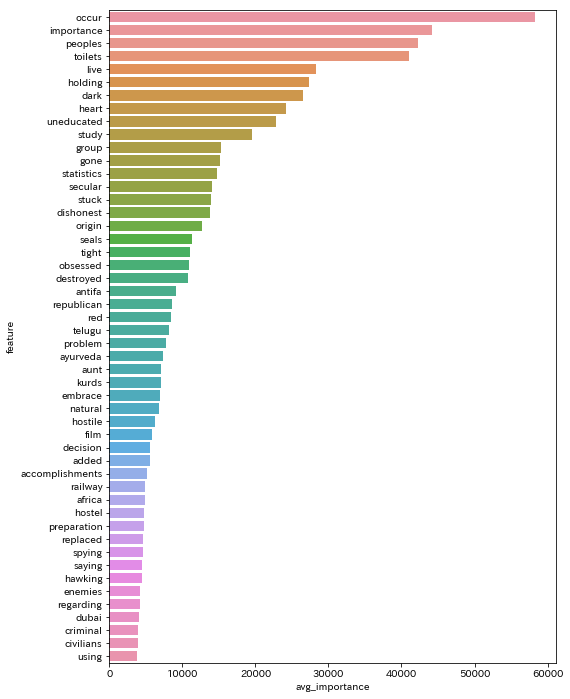

Selece Feature: 2365
[Save Feature Importance] done in 0 s
2365
['aap', 'able', 'abortion', 'abortions', 'abroad', 'abuse', 'abused', 'abusing', 'abusive', 'academy', 'accept', 'acceptable', 'access', 'accomplishments', 'account', 'achieve', 'acknowledge', 'act', 'acting', 'actions', 'active', 'activists', 'actually', 'adam', 'add', 'added', 'addicted', 'addicts', 'address', 'administration', 'admission', 'admit', 'adopt', 'ads', 'adultery', 'adults', 'advantages', 'advice', 'affairs', 'affect', 'affected', 'affirmative', 'afghan', 'afraid', 'africa', 'african', 'africans', 'age', 'agenda', 'agents', 'aggressive', 'ago', 'agree', 'agreement', 'ai', 'aids', 'air', 'aircraft', 'aka', 'al', 'alabama', 'albanians', 'alex', 'alien', 'aliens', 'alive', 'allah', 'alleged', 'allow', 'allowed', 'allowing', 'alt', 'amazon', 'amendment', 'america', 'american', 'americans', 'anal', 'analysis', 'ancestors', 'ancient', 'android', 'animal', 'animals', 'anime', 'annoy', 'annoying', 'answer', 'answerin

In [30]:
with timer("Selected Train"):
    select_features, prediction = lgbm_train(select_mx, select_features, fold=5)
    print(len(select_features))
    print(select_features)

In [14]:
print(f'All Done!! {time.time() - train_st_time:.0f} s')

NameError: name 'train_st_time' is not defined